In [4]:
from typing import Annotated,Sequence,TypedDict
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,SystemMessage,ToolMessage
from langgraph.graph import StateGraph,START,END
from langchain_community.chat_models import ChatTongyi
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

load_dotenv()

True

Annotated - Provides additional context without affectng the type itself  
Sequence - To automatically handle the state updates for sequences such as by adding new messages to a chat history  

Reducer Function -
Rule that controls how updates from nodes are combined with the existing state.
Tells us how to merge new data into the current state.  
Without a reducer , updates would have replaced the existing value entirely!

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [20]:
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b
@tool
def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

tools=[add, subtract, multiply]

llm= ChatTongyi(model="qwen-plus").bind_tools(tools)

In [21]:
def model_call(state: AgentState) -> AgentState:
    system_prompt=SystemMessage(
        content="You are my AI assistant, please answer my quary to the best of your ability.")
    response=llm.invoke([system_prompt]+state["messages"])
    return {"messages":response}

def should_continue(state: AgentState):
    messages=state["messages"]
    last_message=messages[-1]
    if not last_message.tool_calls:
        return "END"
    else:
        return "continue"
    
graph = StateGraph(AgentState)
tool_node= ToolNode(
    tools=tools
)
graph.add_node("our_agent", model_call)
graph.add_node("tool_node", tool_node)

graph.add_edge(START, "our_agent")
graph.add_conditional_edges(
    "our_agent",should_continue,{"continue": "tool_node", "END": END})
graph.add_edge("tool_node", "our_agent")
agent=graph.compile()

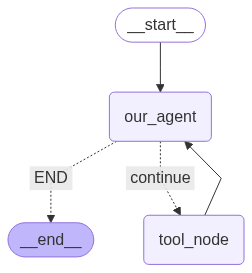

In [22]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))


In [23]:
def print_stream(stream):
    for s in stream:
        message=s["messages"][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

In [25]:
mess={"messages": ["User: 17+52 等于几?,18*24呢？然后对我讲一个笑话"]}
print_stream(agent.stream(mess,stream_mode="values"))

================================ Human Message =================================

User: 17+52 等于几?,18*24呢？然后对我讲一个笑话
================================== Ai Message ==================================
Tool Calls:
  add (call_1772e1dffcfa4ccc97ec8c)
 Call ID: call_1772e1dffcfa4ccc97ec8c
  Args:
    a: 17
    b: 52
================================= Tool Message =================================
Name: add

69
================================== Ai Message ==================================
Tool Calls:
  multiply (call_a2079d6f287944908f23c3)
 Call ID: call_a2079d6f287944908f23c3
  Args:
    a: 18
    b: 24
================================= Tool Message =================================
Name: multiply

432
================================== Ai Message ==================================

计算结果为：17+52等于69，18*24等于432。

这是一个笑话给您：为什么电脑很差劲时会感到非常沮丧？ 因为它知道，无论如何努力，某些程序始终无法“运行”！


```json
{'messages': [HumanMessage(content='User: 17+52 等于几?,18+24呢？', additional_kwargs={}, response_metadata={}, id='08dfcca3-8e8e-48e3-b021-82e4d1d507b3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_de97ecf95c2547849794af', 'type': 'function', 'function': {'name': 'add', 'arguments': '{"a": 17, "b": 52}'}}]}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': '575b19b4-1db7-947a-bf2e-6b6f33883711', 'token_usage': {'input_tokens': 204, 'output_tokens': 24, 'total_tokens': 228, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--a13c09f6-9454-43db-93e2-763f1fc73a38-0', tool_calls=[{'name': 'add', 'args': {'a': 17, 'b': 52}, 'id': 'call_de97ecf95c2547849794af', 'type': 'tool_call'}]),
  ToolMessage(content='69', name='add', id='d63563ef-b87c-4185-91be-5debfdd57538', tool_call_id='call_de97ecf95c2547849794af'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ed75d2b9b9d24e778b06ca', 'type': 'function', 'function': {'name': 'add', 'arguments': '{"a": 18, "b": 24}'}}]}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': '80cda3e9-e131-9688-9b32-699888f97dfb', 'token_usage': {'input_tokens': 239, 'output_tokens': 26, 'total_tokens': 265, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--af42a47a-3120-4671-aab1-5fbce28ecd82-0', tool_calls=[{'name': 'add', 'args': {'a': 18, 'b': 24}, 'id': 'call_ed75d2b9b9d24e778b06ca', 'type': 'tool_call'}]),
  ToolMessage(content='42', name='add', id='be3957bd-97ef-406e-98e8-61067b277d12', tool_call_id='call_ed75d2b9b9d24e778b06ca'),
  AIMessage(content='17 + 52 等于 69，而 18 + 24 等于 42。', additional_kwargs={}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'stop', 'request_id': 'b1d65b51-9e45-9252-b268-9ab34c7e8ad1', 'token_usage': {'input_tokens': 276, 'output_tokens': 32, 'total_tokens': 308, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--940048a9-5c28-4d67-b8bf-9e4e427d0683-0')]}